# 48. 세상에서 가장 시니컬한 전략 ! 종가 매수, 시가 매도

[48강의](https://www.youtube.com/watch?v=CDexze4Cas0) 를 파이썬으로 구현해보겠습니다.

## 설치

Pandas, Numpy가 있어야 합니다. 설치가 안되어있으시면 다음 셀을 실행시키세요.

In [1]:
import sys
!{sys.executable} -m pip install pandas numpy 2&>1 >/dev/null

## 다운로드 (전세계 주식 일별 데이터)

[stooq](http://stooq.com/) 에서 받으세요

편의를 위해서 아래 셀들을 실행시키시면 저절로 다운받아 드립니다.

In [2]:
! file="kospi_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^kospi&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="nkx_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^nkx&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="shc_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^shc&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="ndq_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^ndq&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="dji_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^dji&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="spx_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^spx&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="rts_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^rts&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null
! file="snx_daily.csv"; test -f ${file} || wget "https://stooq.com/q/d/l/?s=^snx&d1=19800101&d2=20190222&i=d" -O ${file} 2&>1 >/dev/null

## 종가매수 + 시가매도 전략이 뭐냐?

- 종가에 구입 
- 다음날 시작할때 매도
- 수수료 0.015% 적용 (한번 사거나 팔때마다)

In [3]:
import pandas as pd
import numpy as np
# 아래는 차트를 쓰기 위한 라이브러리들입니다.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('legend',fontsize=20);

In [4]:
filepath = 'kospi_daily.csv'
df = pd.read_csv(filepath)[['Date', 'Open', 'High', 'Low', 'Close']]
df.head()

,Date,Open,High,Low,Close
0,1980-01-04,100.00,100.00,100.00,100.00
1,1980-01-05,100.15,100.15,100.15,100.15
2,1980-01-07,102.53,102.53,102.53,102.53
3,1980-01-08,105.28,105.28,105.28,105.28
4,1980-01-09,106.37,106.37,106.37,106.37


In [5]:
df['Close2'] = df['Close'].shift(1)
df['수익률'] = (df['Open'] / df['Close2'] - 1) - 0.0003
df['전략퓨어'] = (df['수익률'] + 1).cumprod()
df['전략퓨어 MAX'] = df['전략퓨어'].cummax()
df['전략퓨어 MDD'] = df['전략퓨어'] / df['전략퓨어 MAX'] - 1

df['3일평균종가'] = df['Close2'].rolling(3).mean()
df['수익률3'] = np.where(df['Close2'] > df['3일평균종가'], (df['Open'] / df['Close2'] - 1) - 0.0003, 0)
df['모멘텀3'] = (df['수익률3'] + 1).cumprod()
df['모멘텀3 MAX'] = df['모멘텀3'].cummax()
df['모멘텀3 MDD'] = df['모멘텀3'] / df['모멘텀3 MAX'] - 1

df['5일평균종가'] = df['Close2'].rolling(5).mean()
df['수익률5'] = np.where(df['Close2'] > df['5일평균종가'], (df['Open'] / df['Close2'] - 1) - 0.0003, 0)
df['모멘텀5'] = (df['수익률5'] + 1).cumprod()
df['모멘텀5 MAX'] = df['모멘텀5'].cummax()
df['모멘텀5 MDD'] = df['모멘텀5'] / df['전략퓨어 MAX'] - 1

df[['Date', '전략퓨어', '모멘텀3', '모멘텀5']].tail()

,Date,전략퓨어,모멘텀3,모멘텀5
10506,2019-02-18,10.726124,145.262422,130.591819
10507,2019-02-19,10.713542,145.262422,130.438641
10508,2019-02-20,10.764294,145.950546,130.438641
10509,2019-02-21,10.734513,145.546755,130.077765
10510,2019-02-22,10.702634,145.114515,129.691465


In [6]:
print('전략퓨어 MDD: {:.2f}'.format(df['전략퓨어 MDD'].min()))
print('모멘텀3 MDD: {:.2f}'.format(df['모멘텀3 MDD'].min()))
print('모멘텀5 MDD: {:.2f}'.format(df['모멘텀5 MDD'].min()))

전략퓨어 MDD: -0.76
모멘텀3 MDD: -0.35
모멘텀5 MDD: -0.19


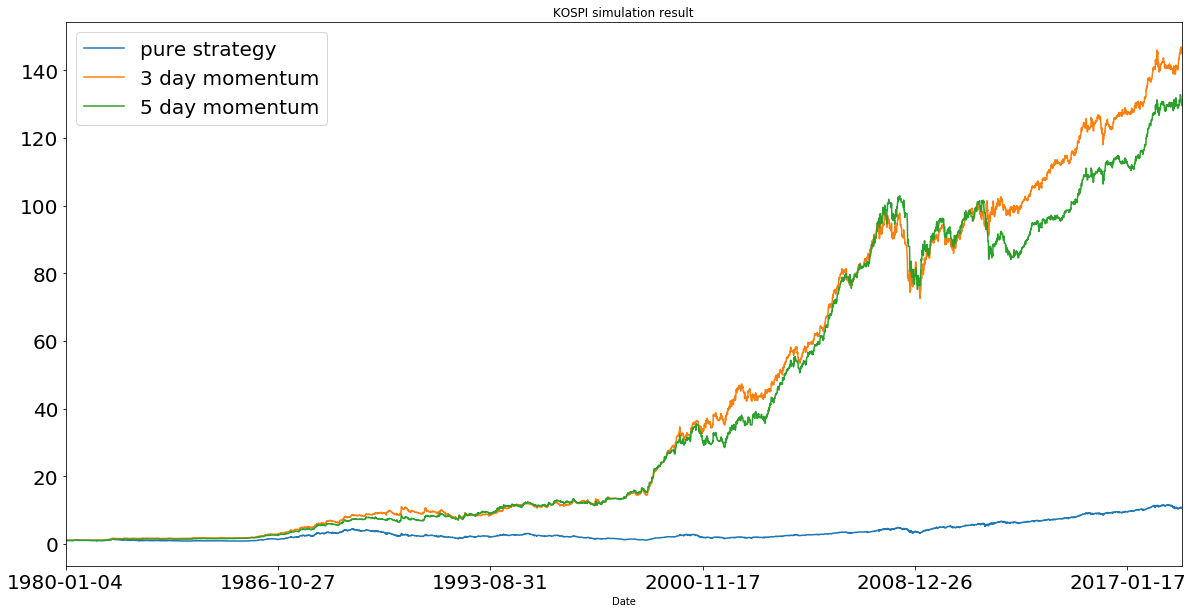

In [7]:
(df.set_index('Date')[['전략퓨어', '모멘텀3', '모멘텀5']]
   .rename({'전략퓨어': 'pure strategy',
            '모멘텀3': '3 day momentum',
            '모멘텀5': '5 day momentum'
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='KOSPI simulation result'));

되게 웃깁니다. 종가매수 + 시가매도 + 모멘텀만 해도 엄청 잘 버네요. 

KOSPI 지수처럼 투자했으면 1980년부터 시작했으면 20배 버는건데... 100배 이상으로 그냥 훌쩍 넘네요.

한국시장 진짜 퀀트하기 좋습니다. ㅎㅎ

## 세계 시장에서 테스트

여러 시장에서 같이 돌려보고 그래프를 같이 그려보죠. 3일 평균만 그려보겠습니다.

In [8]:
filepaths = [
    'dji_daily.csv',
    'ndq_daily.csv',
    'nkx_daily.csv',
    'rts_daily.csv',
    'shc_daily.csv',
    'snx_daily.csv',
    'spx_daily.csv'
]
dfs = {filepath[:3]: pd.read_csv(filepath)[['Date', 'Open', 'High', 'Low', 'Close']]
       for filepath in filepaths}
dfs['dji'].head()

,Date,Open,High,Low,Close
0,1980-01-02,838.7,841.2,822.4,824.6
1,1980-01-03,824.6,827.7,809.0,820.3
2,1980-01-04,820.3,833.5,819.0,828.8
3,1980-01-07,828.8,839.9,824.7,832.0
4,1980-01-08,832.0,853.7,828.8,851.7


In [9]:
dfs2 = []
for market, df in dfs.items():
    df['Close2'] = df['Close'].shift(1)
    df['3일평균종가'] = df['Close2'].rolling(3).mean()
    df['수익률3'] = np.where(df['Close2'] > df['3일평균종가'], (df['Open'] / df['Close2'] - 1) - 0.0003, 0)
    df[market] = (df['수익률3'] + 1).cumprod()
    dfs2.append(df[['Date', market]].set_index('Date'))
    
df = dfs2[0]
for df2 in dfs2[1:]:
    df = df.join(df2, how='inner')
    
df.tail()

,dji,ndq,nkx,rts,shc,snx,spx
Date,,,,,,,
2019-02-15,0.220015,10.484594,2.954944,48.029629,69.532940,17308.382223,0.204086
2019-02-19,0.219665,10.451057,2.950549,48.118986,69.641838,17308.382223,0.203560
2019-02-20,0.219438,10.452864,2.955674,48.118986,69.757669,17308.382223,0.203447
2019-02-21,0.219101,10.430662,2.953521,48.127514,69.704405,17334.658825,0.203060
2019-02-22,0.219101,10.430662,2.942614,48.047076,69.704405,17332.669591,0.203060


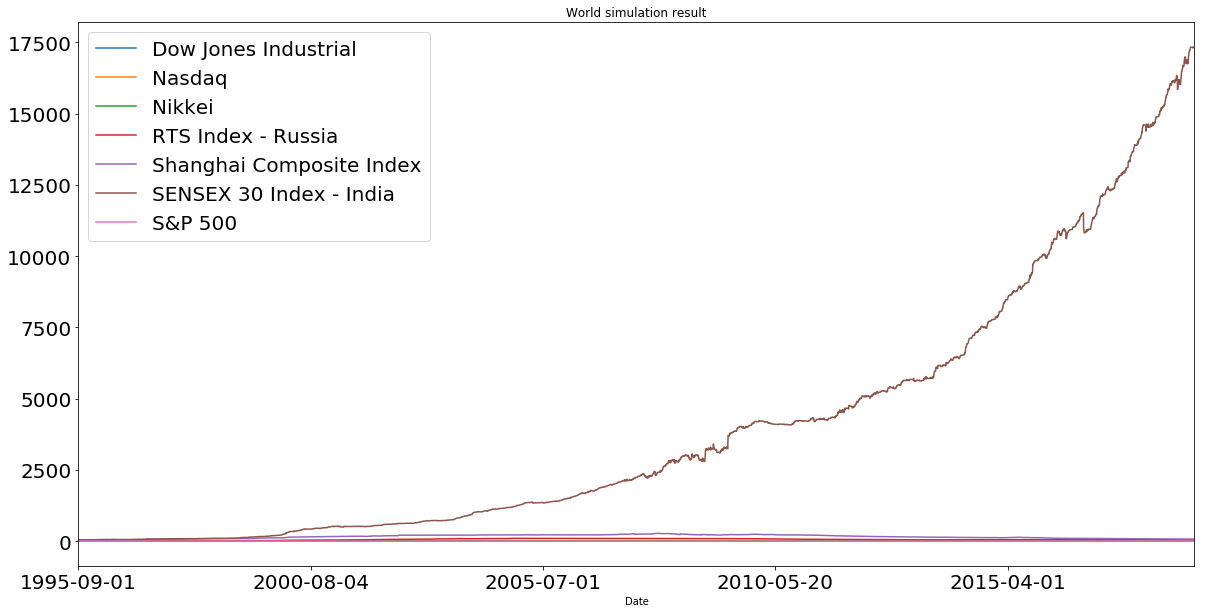

In [10]:
(df.rename({'dji': 'Dow Jones Industrial',
            'ndq': 'Nasdaq',
            'nkx': 'Nikkei',
            'rts': 'RTS Index - Russia',
            'shc': 'Shanghai Composite Index',
            'snx': 'SENSEX 30 Index - India',
            'spx': 'S&P 500',
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='World simulation result'));

한국 KOSPI 는 저리가라입니다. 인도에서 같은 전략을 쓰면 17500배를 버네요. lol

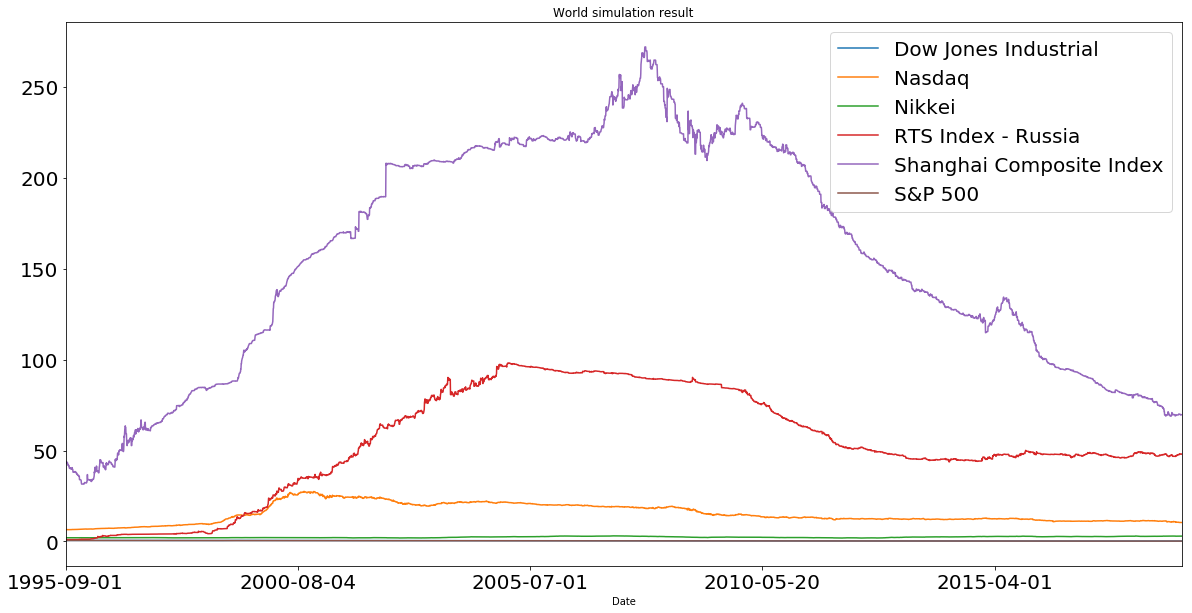

In [11]:
(df[['dji', 'ndq', 'nkx', 'rts', 'shc', 'spx']]
   .rename({'dji': 'Dow Jones Industrial',
            'ndq': 'Nasdaq',
            'nkx': 'Nikkei',
            'rts': 'RTS Index - Russia',
            'shc': 'Shanghai Composite Index',
            'spx': 'S&P 500',
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='World simulation result'));

중국은 좀 이상합니다. 2005년까지는 비슷하게 먹다가 그 후에는 하락하네요. 뭔가 구리지만... 그렇다네요.

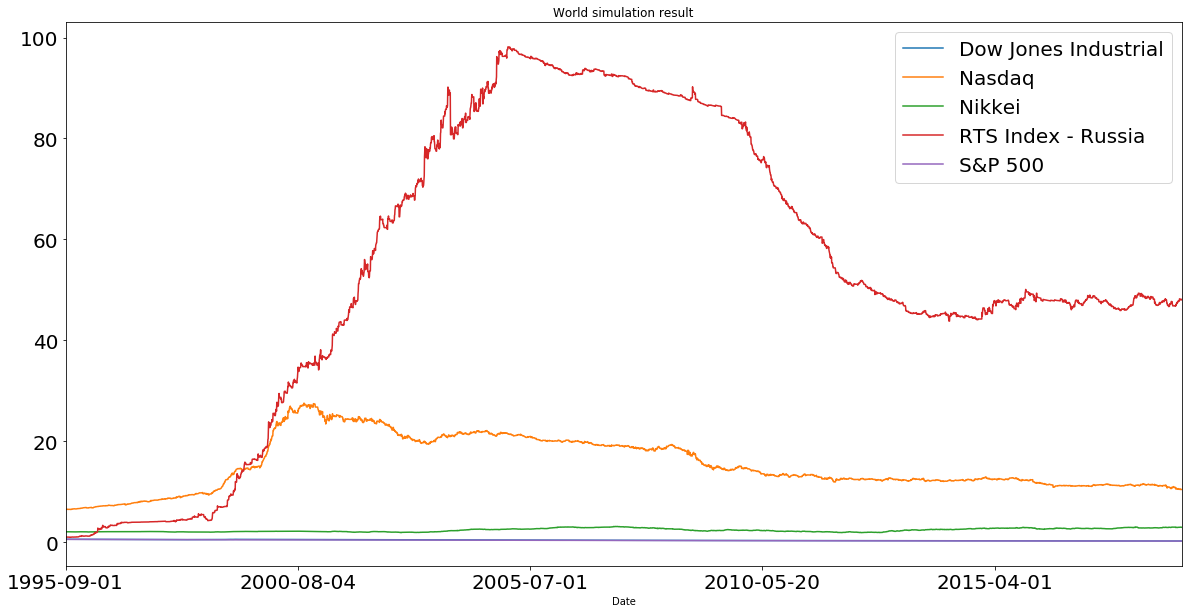

In [12]:
(df[['dji', 'ndq', 'nkx', 'rts', 'spx']]
   .rename({'dji': 'Dow Jones Industrial',
            'ndq': 'Nasdaq',
            'nkx': 'Nikkei',
            'rts': 'RTS Index - Russia',
            'spx': 'S&P 500',
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='World simulation result'));

러시아도 03년 이후에 뭔가 하락이구요.

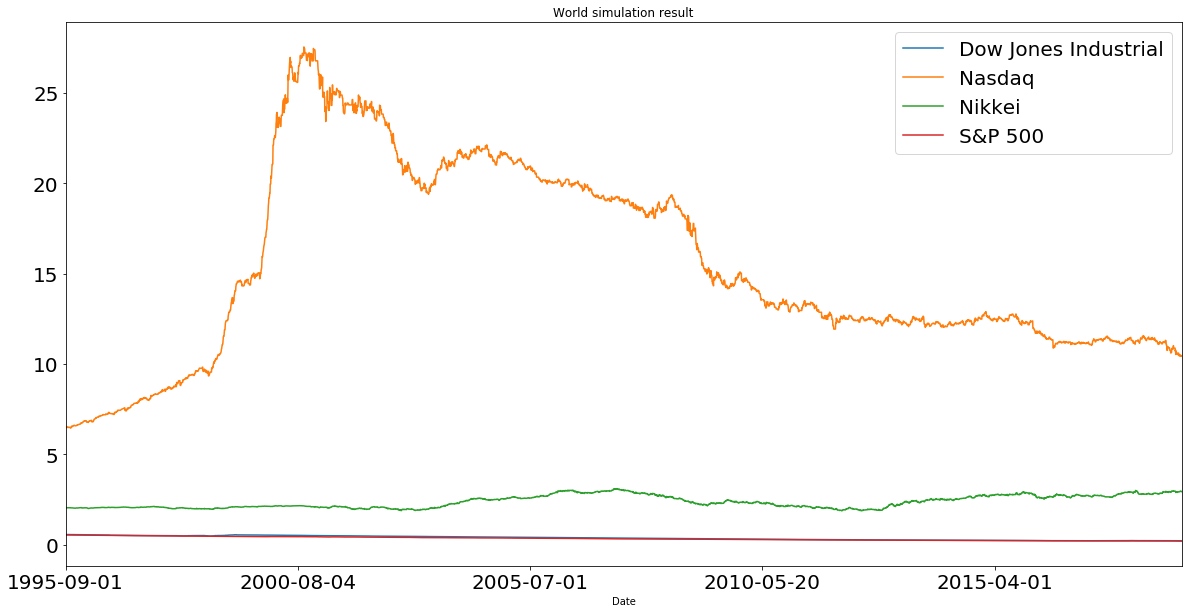

In [13]:
(df[['dji', 'ndq', 'nkx', 'spx']]
   .rename({'dji': 'Dow Jones Industrial',
            'ndq': 'Nasdaq',
            'nkx': 'Nikkei',
            'spx': 'S&P 500',
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='World simulation result'));

그 다음은 나스닥입니다. 00년 버블까지는 전략이 잘먹다가 그 후에는 잃어요.

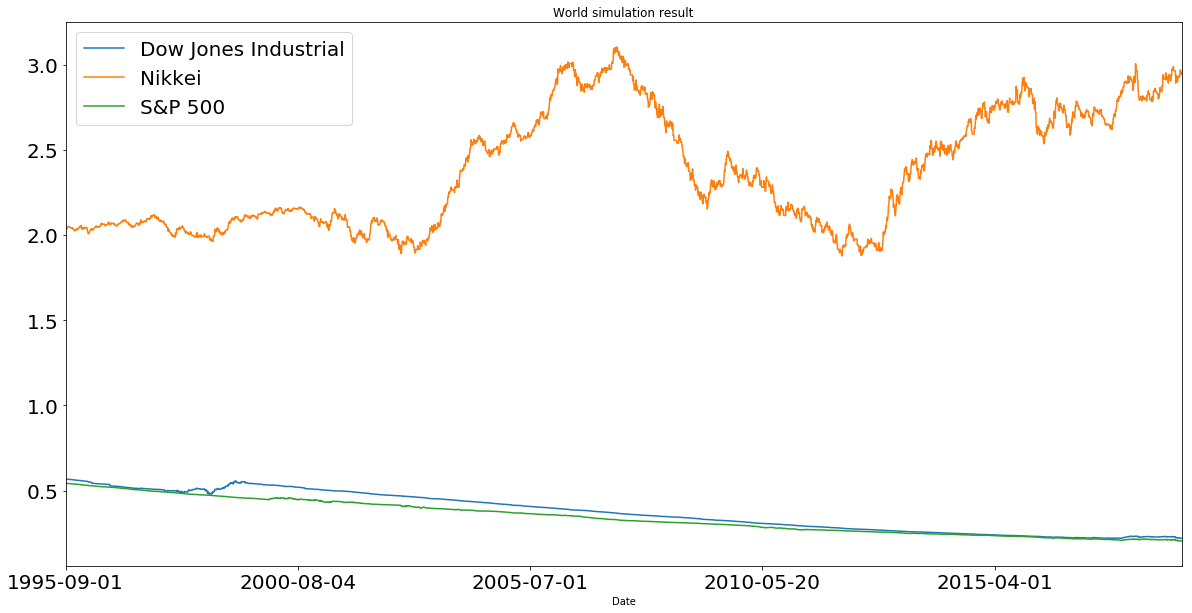

In [14]:
(df[['dji', 'nkx', 'spx']]
   .rename({'dji': 'Dow Jones Industrial',
            'nkx': 'Nikkei',
            'spx': 'S&P 500',
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='World simulation result'));

일본도 좋지는 않습니다. 이 전략으로 수십년 투자해야 겨우 원금 2배에서 왔다갔다 하네요. 절대 하면 안되죠.

마지막 다우존스나 S&P 500 은 돈을 줄창 잃습니다. 절대 하시면 안되요!

## KOSDAQ

KOSDAQ 데이터는 [investing.com](https://www.investing.com/indices/kosdaq-historical-data) 에 있습니다. Price 를 Close 로 바꿔서 하면 되네요.

참고로 investing.com 은 가입을 해서 다운받아야 하기 때문에, wget 으로 다운받는 코드는 여기 없습니다. "kosdaq_daily.csv" 로 파일을 다운받으셨다고 가정하겠습니다.

In [15]:
filepath = 'kosdaq_daily.csv'
df = (pd.read_csv(filepath, parse_dates=['Date'])[['Date', 'Open', 'Price']]
        .rename({'Price': 'Close'}, axis='columns')
        .sort_values(by='Date'))
df.head()

,Date,Open,Close
4485,2001-01-02,502.5,557.0
4484,2001-01-03,545.8,569.0
4483,2001-01-04,617.7,615.1
4482,2001-01-05,614.5,625.2
4481,2001-01-08,614.9,650.0


In [16]:
df['Close2'] = df['Close'].shift(1)
df['3일평균종가'] = df['Close2'].rolling(3).mean()
df['수익률3'] = np.where(df['Close2'] > df['3일평균종가'], (df['Open'] / df['Close2'] - 1) - 0.0003, 0)
df['모멘텀3'] = (df['수익률3'] + 1).cumprod()
df['모멘텀3 MAX'] = df['모멘텀3'].cummax()
df['모멘텀3 MDD'] = df['모멘텀3'] / df['모멘텀3 MAX'] - 1
df.tail()

,Date,Open,Close,Close2,3일평균종가,수익률3,모멘텀3,모멘텀3 MAX,모멘텀3 MDD
4,2019-02-18,743.53,745.33,738.66,740.280000,0.000000,4312.989743,4318.590704,-0.001297
3,2019-02-19,746.50,748.05,745.33,742.086667,0.001270,4318.466267,4318.590704,-0.000029
2,2019-02-20,749.52,750.69,748.05,744.013333,0.001665,4325.656986,4325.656986,0.000000
1,2019-02-21,752.30,747.33,750.69,748.023333,0.001845,4333.636497,4333.636497,0.000000
0,2019-02-22,747.25,743.38,747.33,748.690000,0.000000,4333.636497,4333.636497,0.000000


In [17]:
print('모멘텀3 MDD: {:.2f}'.format(df['모멘텀3 MDD'].min()))

모멘텀3 MDD: -0.08


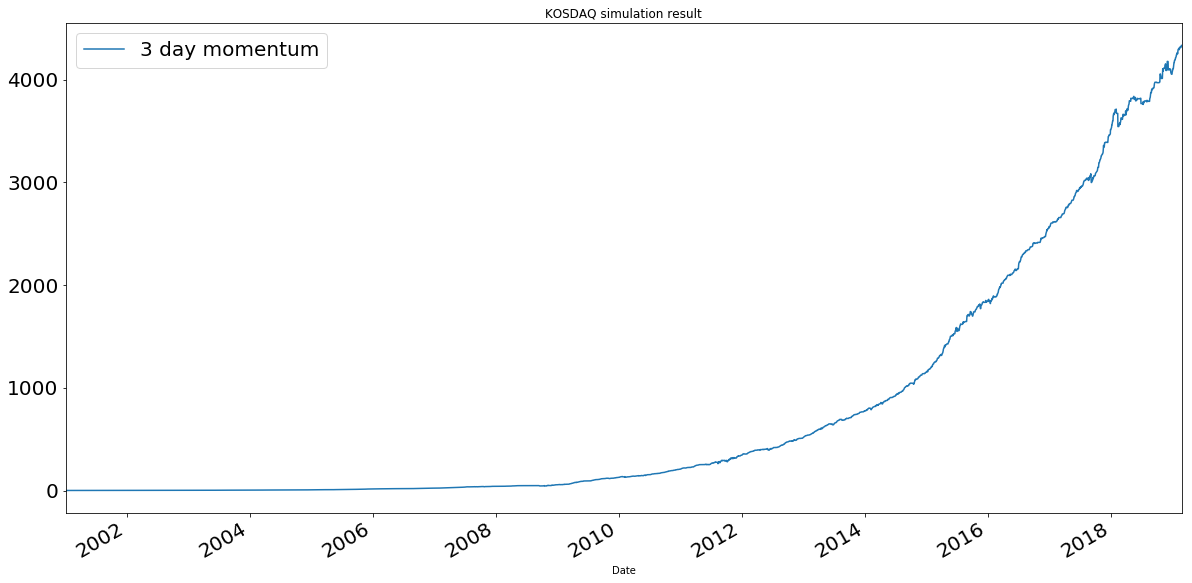

In [18]:
(df.set_index('Date')[['모멘텀3']]
   .rename({'모멘텀3': '3 day momentum'
           }, axis='columns')
   .plot(figsize=(20, 10), fontsize=20, title='KOSDAQ simulation result'));

네... KOSDAQ 장난아니네요. 인도 다음의 최고 시장입니다!

## 결론

- 시장이 덜 성숙할수록 이런 말도 안되는 전략이 잘 먹힌다
- 거래세 사라지면 개별종목에서 하라!
- [강의 커멘트들](https://www.youtube.com/watch?v=CDexze4Cas0)에 보면 실제로 이 전략으로 거래하시는 분들도 계심. systrader79 및 그 학생분들이 비슷한 전략을 쓰신다고!